# Comparing simulated trajectories from coupled and uncoupled simulation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from datetime import timedelta, datetime
from geopy import distance

## Loading trajectory data

In [2]:
datapath = '/Users/siren/IMMERSE_waves/develop-mac/data/'
trajpath_csd1 = datapath + 'Parcels_CalcTraj_Data-coupled-sd_Release-GulfOfLion-d0_Integrate-fw-d30_Sample-tau-UV.nc'
trajpath_csd2 = datapath + 'Parcels_CalcTraj_Data-coupled-sd_Release-GulfOfLion-d5_Integrate-fw-d30_Sample-tau-UV.nc'
trajpath_csd3 = datapath + 'Parcels_CalcTraj_Data-coupled-sd_Release-GulfOfLion-d10_Integrate-fw-d30_Sample-tau-UV.nc'
trajpath_csd4 = datapath + 'Parcels_CalcTraj_Data-coupled-sd_Release-GulfOfLion-d15_Integrate-fw-d30_Sample-tau-UV.nc'
trajpath_csd5 = datapath + 'Parcels_CalcTraj_Data-coupled-sd_Release-GulfOfLion-d20_Integrate-fw-d30_Sample-tau-UV.nc'
trajpath_csd6 = datapath + 'Parcels_CalcTraj_Data-coupled-sd_Release-GulfOfLion-d25_Integrate-fw-d30_Sample-tau-UV.nc'
traj_csd = xr.open_mfdataset((trajpath_csd1, trajpath_csd2, trajpath_csd3, trajpath_csd4, trajpath_csd5, trajpath_csd6),
                            concat_dim='start', combine='nested')

trajpath_nc1 = datapath + 'Parcels_CalcTraj_Data-uncoupled_Release-GulfOfLion-d0_Integrate-fw-d30_Sample-tau-UV.nc'
trajpath_nc2 = datapath + 'Parcels_CalcTraj_Data-uncoupled_Release-GulfOfLion-d5_Integrate-fw-d30_Sample-tau-UV.nc'
trajpath_nc3 = datapath + 'Parcels_CalcTraj_Data-uncoupled_Release-GulfOfLion-d10_Integrate-fw-d30_Sample-tau-UV.nc'
trajpath_nc4 = datapath + 'Parcels_CalcTraj_Data-uncoupled_Release-GulfOfLion-d15_Integrate-fw-d30_Sample-tau-UV.nc'
trajpath_nc5 = datapath + 'Parcels_CalcTraj_Data-uncoupled_Release-GulfOfLion-d20_Integrate-fw-d30_Sample-tau-UV.nc'
trajpath_nc6 = datapath + 'Parcels_CalcTraj_Data-uncoupled_Release-GulfOfLion-d25_Integrate-fw-d30_Sample-tau-UV.nc'
traj_nc = xr.open_mfdataset((trajpath_nc1, trajpath_nc2, trajpath_nc3, trajpath_nc4, trajpath_nc5, trajpath_nc6),
                            concat_dim='start', combine='nested')

trajpath_cnosd1 = datapath + 'Parcels_CalcTraj_Data-coupled-nosd_Release-GulfOfLion-d0_Integrate-fw-d30_Sample-tau-UV.nc'
trajpath_cnosd2 = datapath + 'Parcels_CalcTraj_Data-coupled-nosd_Release-GulfOfLion-d5_Integrate-fw-d30_Sample-tau-UV.nc'
trajpath_cnosd3 = datapath + 'Parcels_CalcTraj_Data-coupled-nosd_Release-GulfOfLion-d10_Integrate-fw-d30_Sample-tau-UV.nc'
trajpath_cnosd4 = datapath + 'Parcels_CalcTraj_Data-coupled-nosd_Release-GulfOfLion-d15_Integrate-fw-d30_Sample-tau-UV.nc'
trajpath_cnosd5 = datapath + 'Parcels_CalcTraj_Data-coupled-nosd_Release-GulfOfLion-d20_Integrate-fw-d30_Sample-tau-UV.nc'
trajpath_cnosd6 = datapath + 'Parcels_CalcTraj_Data-coupled-nosd_Release-GulfOfLion-d25_Integrate-fw-d30_Sample-tau-UV.nc'
traj_cnosd = xr.open_mfdataset((trajpath_cnosd1, trajpath_cnosd2, trajpath_cnosd3, trajpath_cnosd4, trajpath_cnosd5, trajpath_cnosd6),
                               concat_dim='start',combine='nested')

## Check whether particles beached

In [3]:
def calc_npaticles_beached(trajset):
    tmp = trajset.beached.sum(dim=('obs'))
    beached_trajset = (tmp.where(tmp != 0) / tmp.where(tmp != 0)).sum()
    return beached_trajset.values

In [8]:
npart = traj_csd.lat.shape[0] * traj_csd.lat.shape[1]
print('Total number of released particles per dataset:', str(np))
print('number of beached particles:')
print('coupled with Stokes drift:', str(calc_npaticles_beached(traj_csd)),
      ' (', str(round(calc_npaticles_beached(traj_csd)/npart*100)), '%)')
print('coupled without Stokes drift:', str(calc_npaticles_beached(traj_cnosd)),
      ' (', str(round(calc_npaticles_beached(traj_cnosd)/npart*100)), '%)' )
print('uncoupled without Stokes drift:', str(calc_npaticles_beached(traj_nc)),
      ' (', str(round(calc_npaticles_beached(traj_nc)/npart*100)), '%)' )

Total number of released particles per dataset: <module 'numpy' from '/Users/siren/opt/miniconda3/envs/py3_parcels/lib/python3.10/site-packages/numpy/__init__.py'>
number of beached particles:
coupled with Stokes drift: 0.0  ( 0 %)
coupled without Stokes drift: 11.0  ( 5 %)
uncoupled without Stokes drift: 7.0  ( 3 %)


## Estimating impact of ocean-wave coupling on general dispersion statistics

In [9]:
def calc_trajspeed(trajset):
    u = trajset.U * 1852*60 * np.cos(trajset.lat * np.pi/180)
    v = trajset.V * 1852*60
    speed = (u**2 + v**2)**(1/2)
    return speed

In [10]:
trajspeed_csd = calc_trajspeed(traj_csd)
trajspeed_cnosd = calc_trajspeed(traj_cnosd)
trajspeed_nc = calc_trajspeed(traj_nc)

In [21]:
trajspeed_nc.max().values

array(0.6016705)

In [20]:
trajspeed_csd.max().values

array(0.59675991)

In [11]:
def calc_displacement_stats(trajspeed,dtout):
    #dtout is the output frequency in seconds
    # 1. Total displacement for each particle
    ## obtained by integrating over along-track velocities
    dist = ((trajspeed * dtout).cumsum(dim='obs', skipna=True)) # in m
    # 2. Residual displacement 
    ## obtained by subtracting the mean displacement of all particles
    Dist_total = dist.mean(dim=['traj','start'])
    resdist_total = dist - Dist_total
    # 2. Residual displacement - time
    ## obtained by subtracting the mean displacement D of all particles
    ## - released at the same location
    ## - but at different start times
    Dist_time = dist.mean(dim=['start'])
    resdist_time = dist - Dist_time
    # 2. Residual displacement - space
    ## obtained by subtracting the mean displacement of all particles
    ## - released at the same start time
    ## - but at all possible locations  
    Dist_space = dist.mean(dim=['traj'])
    resdist_space = dist - Dist_space
    return dist, resdist_total, resdist_time, resdist_space

In [12]:
dist_csd, resdist_total_csd, resdist_time_csd, resdist_space_csd = calc_displacement_stats(trajspeed_csd,86400)
dist_cnosd, resdist_total_cnosd, resdist_time_cnosd, resdist_space_cnosd = calc_displacement_stats(trajspeed_cnosd,86400)
dist_nc, resdist_total_nc, resdist_time_nc, resdist_space_nc = calc_displacement_stats(trajspeed_nc,86400)

In [14]:
def calc_quantiles(trajdist):
    dist_quantiles = trajdist.chunk(dict(start=-1)).quantile(q=[0, 0.25, 0.5, 0.75, 1], dim=('traj','start'))
    return dist_quantiles

In [15]:
dist_csd_quantiles = calc_quantiles(dist_csd).compute()
resdist_total_csd_quantiles = calc_quantiles(abs(resdist_total_csd)).compute()
resdist_space_csd_quantiles = calc_quantiles(abs(resdist_space_csd)).compute()
resdist_time_csd_quantiles = calc_quantiles(abs(resdist_time_csd)).compute()

dist_cnosd_quantiles = calc_quantiles(dist_cnosd).compute()
resdist_total_cnosd_quantiles = calc_quantiles(abs(resdist_total_cnosd)).compute()
resdist_space_cnosd_quantiles = calc_quantiles(abs(resdist_space_cnosd)).compute()
resdist_time_cnosd_quantiles = calc_quantiles(abs(resdist_time_cnosd)).compute()

dist_nc_quantiles = calc_quantiles(dist_nc).compute()
resdist_total_nc_quantiles = calc_quantiles(abs(resdist_total_nc)).compute()
resdist_space_nc_quantiles = calc_quantiles(abs(resdist_space_nc)).compute()
resdist_time_nc_quantiles = calc_quantiles(abs(resdist_time_nc)).compute()

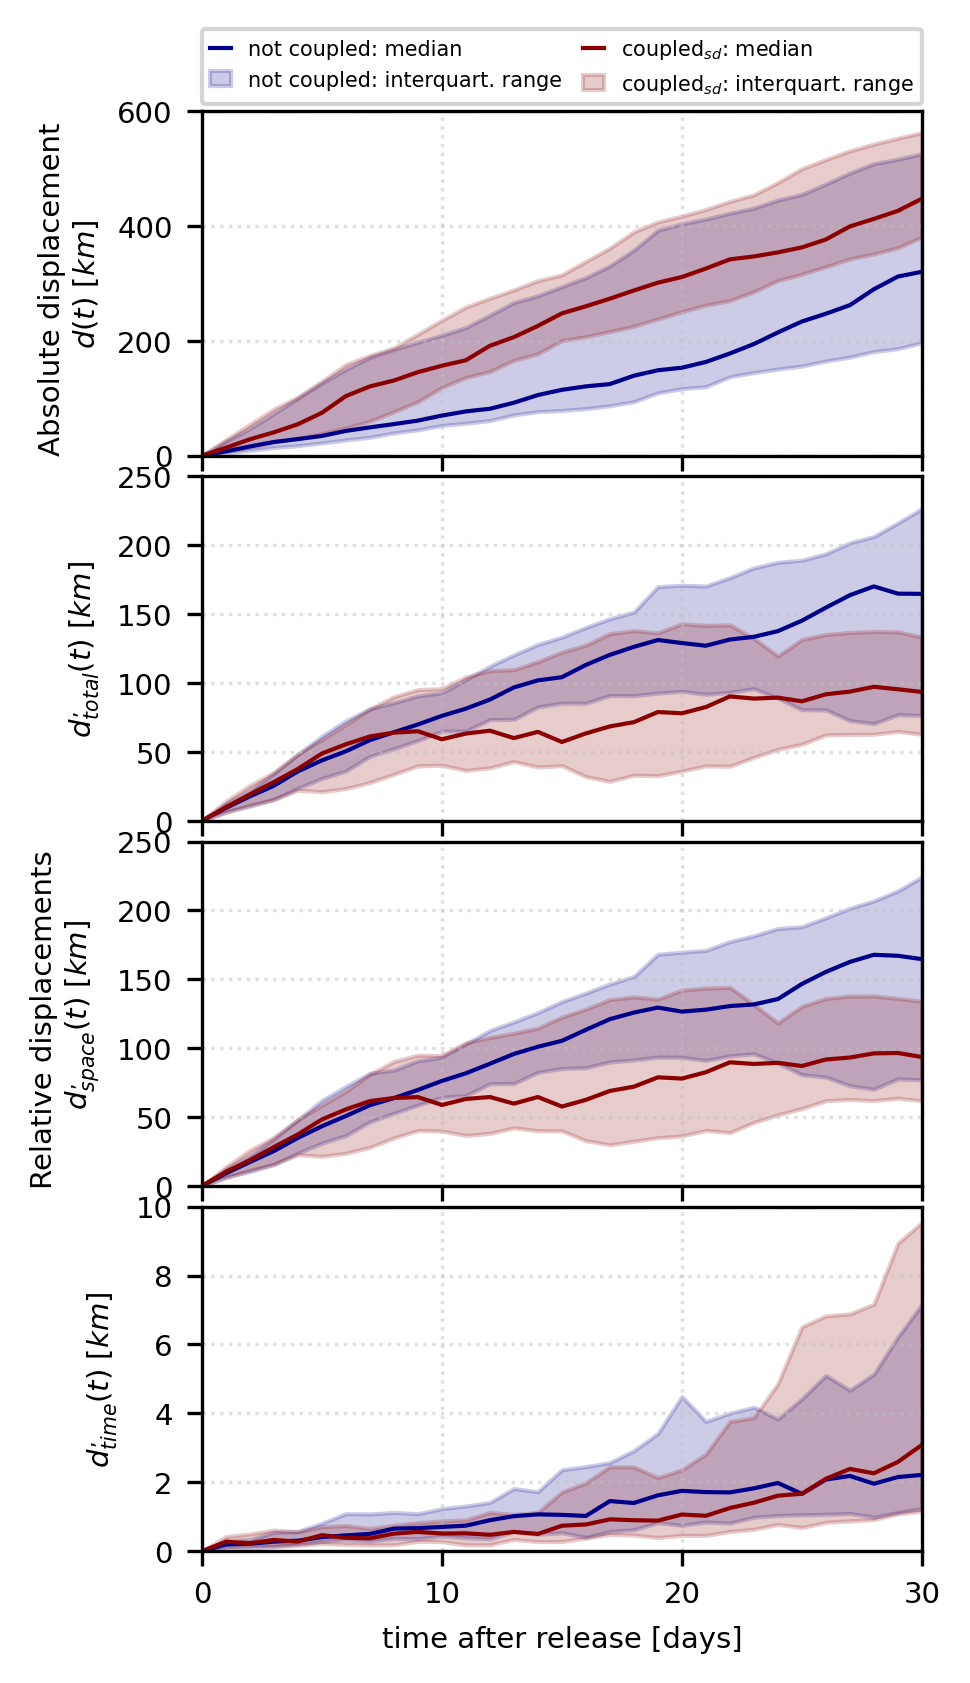

In [16]:
fs1 = 7
fs2 = 5
lw1 = 1
col_csd = 'darkred'
col_nc = 'darkblue'
col_grid = 'silver'
alpha = 0.2
tmin = 1
tmax = 31
tticks = (1,11,21,31)
tticklabs = ('0', '10', '20', '30')


fig = plt.figure(figsize=(3,6),dpi=300)

ax = plt.subplot2grid((4,1),(0,0), rowspan=1, colspan=1)
var_csd = dist_csd_quantiles / 1000
var_nc = dist_nc_quantiles / 1000
ymin = 0
ymax = 600
def plot_main():
    ax.grid(True, linestyle='dotted', which='major', color=col_grid, alpha=0.5)
    plt.plot(var_nc.obs+1,var_nc.isel(quantile=2),
             color=col_nc, linewidth=lw1,
             label='not coupled: median')
    plt.fill_between(var_nc.obs+1,
                     var_nc.isel(quantile=1),var_nc.isel(quantile=3),
                     alpha=alpha, color=col_nc,
                     label='not coupled: interquart. range')
    plt.plot(var_csd.obs+1,var_csd.isel(quantile=2),
             color=col_csd, linewidth=lw1,
             label='coupled$_{sd}$: median')
    plt.fill_between(var_csd.obs+1,
                     var_csd.isel(quantile=1),var_csd.isel(quantile=3),
                     alpha=alpha, color=col_csd,
                     label='coupled$_{sd}$: interquart. range')
    ax.set_xlim(tmin,tmax);
    ax.set_ylim(ymin,ymax);
    ax.set_xticks(tticks); ax.set_xticklabels([])
    ax.tick_params(axis='both', labelsize=fs1)
plot_main()
ax.set_ylabel('Absolute displacement \n$d(t)$ [$km$]', fontsize=fs1)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
          ncol=2, mode="expand", borderaxespad=0.,
         fontsize=fs2, handlelength = 1.0)

ax = plt.subplot2grid((4,1),(1,0), rowspan=1, colspan=1)
ymin = 0
ymax = 250
var_csd = (resdist_total_csd_quantiles) / 1000
var_nc = (resdist_total_nc_quantiles) / 1000
plot_main()
ax.set_ylabel('\n$d^,_{total}(t)$ [$km$]', fontsize=fs1)

ax = plt.subplot2grid((4,1),(2,0), rowspan=1, colspan=1)
ymin = 0
ymax = 250
var_csd = (resdist_space_csd_quantiles) / 1000
var_nc = (resdist_space_nc_quantiles) / 1000
plot_main()
ax.set_ylabel('Relative displacements \n$d^,_{space}(t)$ [$km$]', fontsize=fs1)

ax = plt.subplot2grid((4,1),(3,0), rowspan=1, colspan=1)
ymin = 0
ymax = 10
var_csd = (resdist_time_csd_quantiles) / 1000
var_nc = (resdist_time_nc_quantiles) / 1000
plot_main()
ax.set_xticklabels(tticklabs)
ax.set_ylabel('\n$d^,_{time}(t)$ [$km$]', fontsize=fs1)
ax.set_xlabel('time after release [days]', fontsize=fs1)

plt.subplots_adjust(bottom=0.1, left=0.1, right=0.9, top=0.9,
                    wspace=0.00, hspace=0.06)


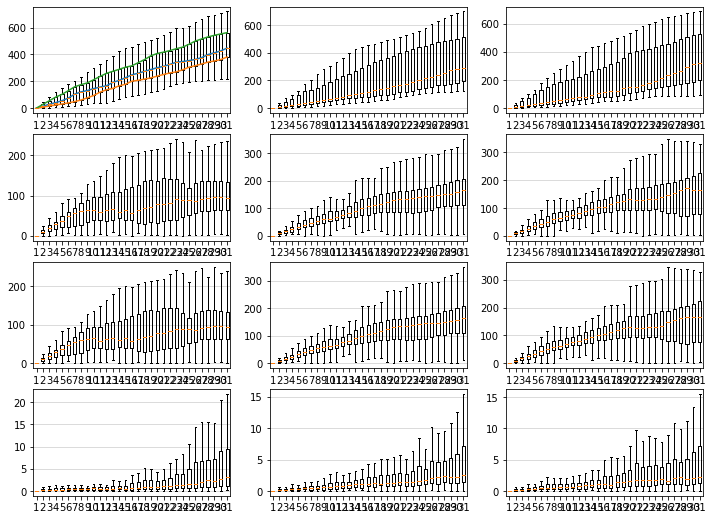

In [17]:
fig, axs = plt.subplots(4,3,figsize=(12,9))
tticks = (1,11,21,31)
tticklabs = ('1', '11', '21', '31')

var = dist_csd.stack(trajstack=('traj','start')).transpose() / 1000
var2 = dist_csd_quantiles / 1000
axs[0,0].boxplot(var,0,'')
axs[0,0].plot(var2.obs+1,var2.isel(quantile=2))
axs[0,0].plot(var2.obs+1,var2.isel(quantile=1))
axs[0,0].plot(var2.obs+1,var2.isel(quantile=3))
axs[0,0].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_total_csd.stack(trajstack=('traj','start')).transpose()) / 1000
axs[1,0].boxplot(var,0,'')
axs[1,0].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_space_csd.stack(trajstack=('traj','start')).transpose()) / 1000
axs[2,0].boxplot(var,0,'')
axs[2,0].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_time_csd.stack(trajstack=('traj','start')).transpose()) / 1000
axs[3,0].boxplot(var,0,'')
axs[3,0].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')


var = dist_cnosd.stack(trajstack=('traj','start')).transpose() / 1000
axs[0,1].boxplot(var,0,'')
axs[0,1].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_total_cnosd.stack(trajstack=('traj','start')).transpose()) / 1000
axs[1,1].boxplot(var,0,'')
axs[1,1].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_space_cnosd.stack(trajstack=('traj','start')).transpose()) / 1000
axs[2,1].boxplot(var,0,'')
axs[2,1].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_time_cnosd.stack(trajstack=('traj','start')).transpose()) / 1000
axs[3,1].boxplot(var,0,'')
axs[3,1].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')


var = dist_nc.stack(trajstack=('traj','start')).transpose() / 1000
axs[0,2].boxplot(var,0,'')
axs[0,2].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_total_nc.stack(trajstack=('traj','start')).transpose()) / 1000
axs[1,2].boxplot(var,0,'')
axs[1,2].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_space_nc.stack(trajstack=('traj','start')).transpose()) / 1000
axs[2,2].boxplot(var,0,'')
axs[2,2].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

var = abs(resdist_time_nc.stack(trajstack=('traj','start')).transpose()) / 1000
axs[3,2].boxplot(var,0,'')
axs[3,2].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')



#axs[1].boxplot(abs(resdist_total_csd)/1000,0,'')
#axs[1].yaxis.grid(True, linestyle='-', which='major', color='lightgrey')

## Quantifying the impact of high wind events

In [ ]:
def calc_trajtau(trajset):
    tau = (trajset.taux**2 + trajset.tauy**2)**1/2
    return tau

In [ ]:
def calc_quantiles_TrajObsVar(trajvar):
    quantiles = trajvar.chunk(dict(start=-1)).quantile(q=[0., 0.1, 0.25, 0.5, 0.75, 0.9, 1],
                                                       dim=('traj','obs','start'))
    return quantiles3D

In [ ]:
trajtau_csd = calc_trajtau(traj_csd)

In [ ]:
trajtau_quantiles_TrajObsVar = calc_quantiles_TrajObsVar(trajtau_csd)

In [ ]:
cols=['red', 'grey', 'darkgrey', 'blue', 'cyan', 'black']
for i in range(6):
    plt.plot(trajtau_csd.isel(start=i), color=cols[i])
#plt.plot(tau.isel(traj=10,start=0))
#plt.plot(tau.isel(traj=0,start=0)*0 + tau_max)
#plt.plot(tau.isel(traj=0,start=0)*0 + tau_90pc)
#plt.plot(tau.isel(traj=0,start=0)*0 + tau_med)
#plt.plot(tau.isel(traj=0,start=0)*0 + tau_25pc)

In [ ]:
plt.hist(tau.stack(stack=('traj','start','obs')), bins = np.arange(tau_min,tau_max,(tau_max-tau_min)/50))